# Neuro-Genomics Course - Home Exercise 2

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Part 1** - Normalization of sequencing data


In [12]:
# plot the algorithms results
def plot_normalization_result(X, Y, corrected_X, corrected_Y, x_cutoff, title):
    # x_cutoff for x-axis - zoom in on histograms
    # Plotting
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"{title}", fontsize=16)
    plt.subplot(2, 2, 1)
    plt.hist(X, bins=10, alpha=0.5, label='X - before', color='blue')
    plt.hist(Y, bins=10, alpha=0.5, label='Y - Before', color='red')
    plt.title('Vectors Histogram Before Normalization')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.hist(corrected_X, bins=10, alpha=0.5, label='X - After', color='blue')
    plt.hist(corrected_Y, bins=10, alpha=0.5, label='Y - After', color='green')
    plt.title('Vectors Histogram After Normalization')
    plt.legend()
    
    # Before normalization
    plt.subplot(2, 2, 3)
    plt.hist(X[X <= x_cutoff], bins=30, alpha=0.5, label='X - Before', color='blue')
    plt.hist(Y[Y <= x_cutoff], bins=30, alpha=0.5, label='Y - Before', color='red')
    plt.title(f'Zoom in Histogram Before Normalization (X-axis <= {x_cutoff})')
    plt.legend()
    plt.xlim(0, x_cutoff)

    # After normalization
    plt.subplot(2, 2, 4)
    plt.hist(X[X <= x_cutoff], bins=30, alpha=0.5, label='X - After', color='blue')
    plt.hist(corrected_Y[corrected_Y <= x_cutoff], bins=30, alpha=0.5, label='Y - After', color='green')
    plt.title(f'Zoom in Histogram After Normalization (X-axis <= {x_cutoff})')
    plt.legend()
    plt.xlim(0, x_cutoff)

    plt.tight_layout()
    plt.show()


#### a) Implement TMM normalization

In [13]:
def tmm_normalization(X, Y, D):
    """TMM normalization method.

    Args:
        X (list or numpy array): Reference vector with values Xi.
        Y (list or numpy array): Normalized vector with values Yi.
        D (float): A constant between 0 and 1.

    Returns:
        X (list or numpy array): The reference vector.
        corrected_Y (list or numpy array):vector Y scaled by the normalization factor.
        factor (float): the normalization factor.

    """
    #Check that X and Y have the same length
    if len(X) != len(Y):
        raise ValueError("X and Y must have the same length")
    if not (0 < D < 1):
        raise ValueError("D must be between 0 and 1")
    

    # Step 1: Compute the M folds and weights
    M_folds = []
    weights = []
    for Xi, Yi in zip(X, Y):
        if Xi != 0 and Yi != 0:
            Mi = np.log(Yi / Xi)
            Wi = np.sqrt((Xi + Yi) / 2) # Compute the weight
            M_folds.append(Mi)
            weights.append(Wi)
    M_folds = np.array(M_folds)
    weights = np.array(weights)

    # Step 2: Sort and trim M folds and compute TMM
    sorted_indices = np.argsort(M_folds)
    sorted_M_folds = M_folds[sorted_indices]
    sorted_weights = weights[sorted_indices]
    # Step 3: Trim the upper and lower percentages of the data
    n = len(M_folds)
    lower_idx = int(np.floor((D / 2) * n)); higher_idx = int(np.ceil((1 - D / 2) * n))
    trimmed_M_folds = sorted_M_folds[lower_idx:higher_idx]; trimmed_weights = sorted_weights[lower_idx:higher_idx]
    # Step 4: Get the TMM
    TMM = np.sum(trimmed_weights * trimmed_M_folds) / np.sum(trimmed_weights)
    # Step 5: Compute the normalization factor
    factor = np.exp(TMM)
    # Step 6: Correct vector Y
    corrected_Y = Y / factor

    plot_normalization_result(X, Y, X, corrected_Y, x_cutoff=250, title="TMM normalization algorithm")

    return X, corrected_Y, factor

#### b) Implement quantile normalization

In [14]:
def quantile_normalization(X, Y):
    """quantile normalization method.

    Args:
        X (list or numpy array): Reference vector with values Xi.
        Y (list or numpy array): Normalized vector with values Yi.

    Returns:
        corrected_X (list or numpy array): vector X normalized.
        corrected_Y (list or numpy array): vector Y normalized.
    """
    # Step 1: Stack the vectors into a matrix
    matrix = np.vstack([X, Y])
    
    # Step 2: Sort each vector (row-wise)
    sorted_matrix = np.sort(matrix, axis=1)
    
    # Step 3: Compute the mean of each column across the vectors
    mean_sorted = np.mean(sorted_matrix, axis=0)

    # Step 4: Replace the values with the corresponding column mean (based on ranks)
    normalized_matrix = np.zeros_like(matrix)
    for idx, vector in enumerate(matrix):
        # Get the ranks of the original values
        ranks = np.argsort(np.argsort(vector))
        # Assign the mean values based on the ranks
        normalized_matrix[idx] = mean_sorted[ranks]
    
    # Return the normalized vectors
    corrected_X, corrected_Y = normalized_matrix[0], normalized_matrix[1]

    plot_normalization_result(X, Y, corrected_X, corrected_Y, x_cutoff=250, title="quantile normalization algorithm")
    return corrected_X, corrected_Y
    

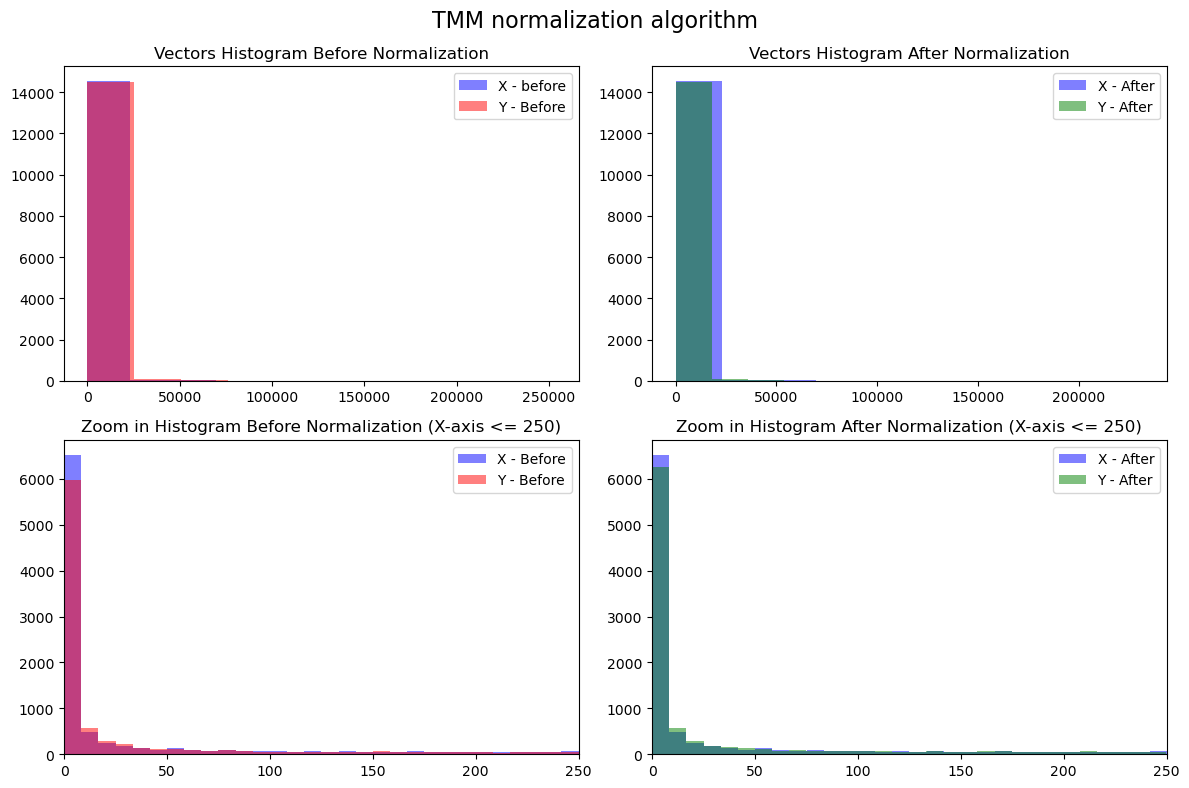

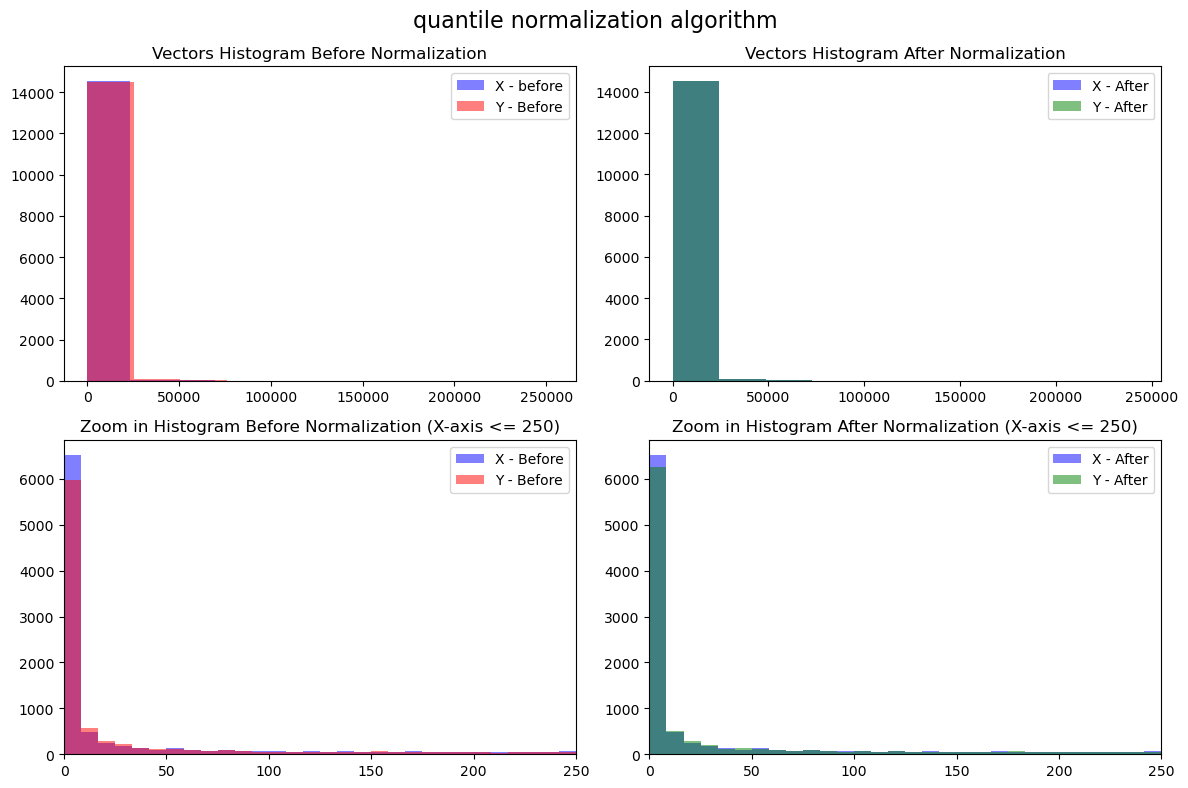

In [15]:

# Run the function on two vectors from the ‘pasilla’ data
file="/Users/adioiz/Documents/Learnings/Neuro-Genomics Course/Home Exc 2/pasilla_gene_counts.tsv"
pasilla_data = pd.read_csv(file, sep='\t', index_col=0)
X = pasilla_data['untreated1'].values
Y = pasilla_data['treated1'].values
D = 0.1

_, Y_normalaized_tmm, normalization_factor = tmm_normalization(X, Y, D)
X_normalaized_quantile, Y_normalaized_quantile = quantile_normalization(X, Y)


# Part 2 - Detect rhythmical patterns using Fourier transform